# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [1]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Configuration

In [2]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.1          # Binary Label Noise probability
disc_factor = np.pi/2    # Similarity of Y_sen to X
n_samples = 2000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions
lmd_interval = np.linspace(-1, 0, 100)
symmetric_fairness = True

## 3. Data Generation

In [3]:
X, Y, Y_sen = generate_synthetic_data(False, n_samples, disc_factor, rnd_seed)
Y_corrupted = add_bin_noise(Y, flip_prob, rnd_seed)
Y_sen_corrupted = add_bin_noise(Y_sen, flip_prob, rnd_seed)

## 4. Model Training

In [4]:
# Split data
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]
Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]

# Initialize and train models
p_reg = LogisticRegression().fit(X_train, Y_train)
p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)
f_reg = LogisticRegression().fit(X_train, Y_sen_train)
f_reg_cor = LogisticRegression().fit(X_train, Y_sen_corr_train)

## 5. Visualization of Decision Boundaries

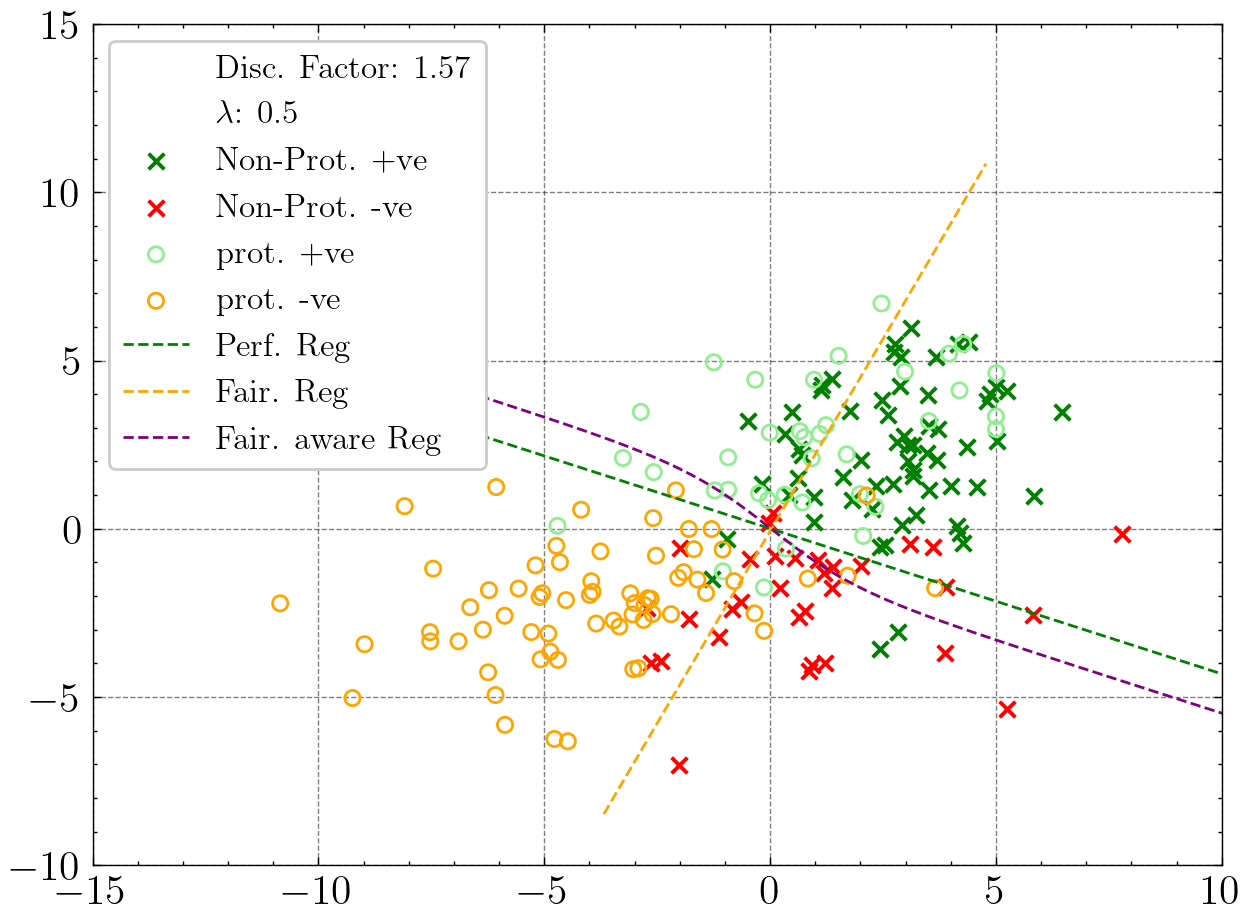

In [5]:
num_to_draw = 200 # we will only draw a small number of points to avoid clutter
x_draw = X[:num_to_draw]
y_draw = Y[:num_to_draw]
Y_sen_draw = Y_sen[:num_to_draw]

X_s_0 = x_draw[Y_sen_draw == 0.0]
X_s_1 = x_draw[Y_sen_draw == 1.0]
y_s_0 = y_draw[Y_sen_draw == 0.0]
y_s_1 = y_draw[Y_sen_draw == 1.0]


# Create a mesh grid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid_points = np.c_[xx.ravel(), yy.ravel()] #(N, 2)

# Predict probabilities for each point on the grid
Y_pred_p = p_reg.predict_proba(grid_points)[:, 1]
Y_pred_p = Y_pred_p.reshape(xx.shape)

Y_pred_f = f_reg.predict_proba(grid_points)[:, 1]
Y_pred_f = Y_pred_f.reshape(xx.shape)
 
Y_pred_all = p_reg.predict_proba(grid_points)[:, 1] - c- lmd * (f_reg.predict_proba(grid_points)[:, 1] - c_bar)
Y_pred_all = Y_pred_all.reshape(xx.shape)

plot_reg( Y_pred_p,Y_pred_f, Y_pred_all, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1, disc_factor, lmd)
#plt.savefig(f"img/Synth_Data_Zafar{df:.2f}_norm_scale.png")

## 6. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
